#패키지 임포트 및 Google Drive 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm

from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#데이터셋 로드

In [ ]:
#구글 드라이브의 디렉토리 입력
train_dir = "/content/drive/MyDrive/[DScover] - 9기 필수 스터디/train"
test_dir = "/content/drive/MyDrive/[DScover] - 9기 필수 스터디/test"

In [ ]:
#이미지 전처리
#사이즈 조정 : 224 * 224
#정규화
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [ ]:
#데이터셋 로드 및 전처리 적용
#ImageFolder가 저절로 라벨을 인식함
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [ ]:
#하이퍼파라미터 설정 : 에포크 및 배치 사이즈
batch_size = 32
num_classes = 10
num_epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#라벨 목록 확인
print("Label List:", train_dataset.classes)

Label List: ['Airbus', 'Boeing', 'Canadair', 'Embraer', 'Eurofighter', 'Lockheed_Martin', 'McDonnell_Douglas', 'Robin', 'Saab', 'Yakovlev']


#모델에 따른 성능 비교 실험

##Vanila CNN Modeling

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 모델 설정

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습하기

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{(correct / total) * 100:.2f}%"
        })

    epoch_acc = correct / total * 100
    print(f"[Epoch {epoch+1}] Total Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# 모델 테스트 및 Confusion Matrix

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in test_pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Epoch 1/10: 100%|██████████| 123/123 [21:20<00:00, 10.41s/it, Loss=1.6243, Acc=36.02%]


[Epoch 1] Total Loss: 217.7066, Accuracy: 36.02%


Epoch 2/10: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s, Loss=1.1631, Acc=46.92%]


[Epoch 2] Total Loss: 171.0996, Accuracy: 46.92%


Epoch 3/10: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s, Loss=1.0872, Acc=62.91%]


[Epoch 3] Total Loss: 118.6561, Accuracy: 62.91%


Epoch 4/10: 100%|██████████| 123/123 [00:16<00:00,  7.65it/s, Loss=0.6701, Acc=77.43%]


[Epoch 4] Total Loss: 72.8678, Accuracy: 77.43%


Epoch 5/10: 100%|██████████| 123/123 [00:15<00:00,  7.72it/s, Loss=0.2359, Acc=86.88%]


[Epoch 5] Total Loss: 42.9399, Accuracy: 86.88%


Epoch 6/10: 100%|██████████| 123/123 [00:15<00:00,  7.85it/s, Loss=0.1465, Acc=93.42%]


[Epoch 6] Total Loss: 23.1913, Accuracy: 93.42%


Epoch 7/10: 100%|██████████| 123/123 [00:15<00:00,  7.75it/s, Loss=0.0865, Acc=95.60%]


[Epoch 7] Total Loss: 15.2648, Accuracy: 95.60%


Epoch 8/10: 100%|██████████| 123/123 [00:15<00:00,  7.71it/s, Loss=0.2113, Acc=96.87%]


[Epoch 8] Total Loss: 11.2422, Accuracy: 96.87%


Epoch 9/10: 100%|██████████| 123/123 [00:15<00:00,  7.72it/s, Loss=0.1241, Acc=98.04%]


[Epoch 9] Total Loss: 7.7290, Accuracy: 98.04%


Epoch 10/10: 100%|██████████| 123/123 [00:15<00:00,  7.73it/s, Loss=0.1666, Acc=98.17%]


[Epoch 10] Total Loss: 6.5064, Accuracy: 98.17%


Evaluating: 100%|██████████| 62/62 [12:08<00:00, 11.76s/it]

Test Accuracy: 73.75%


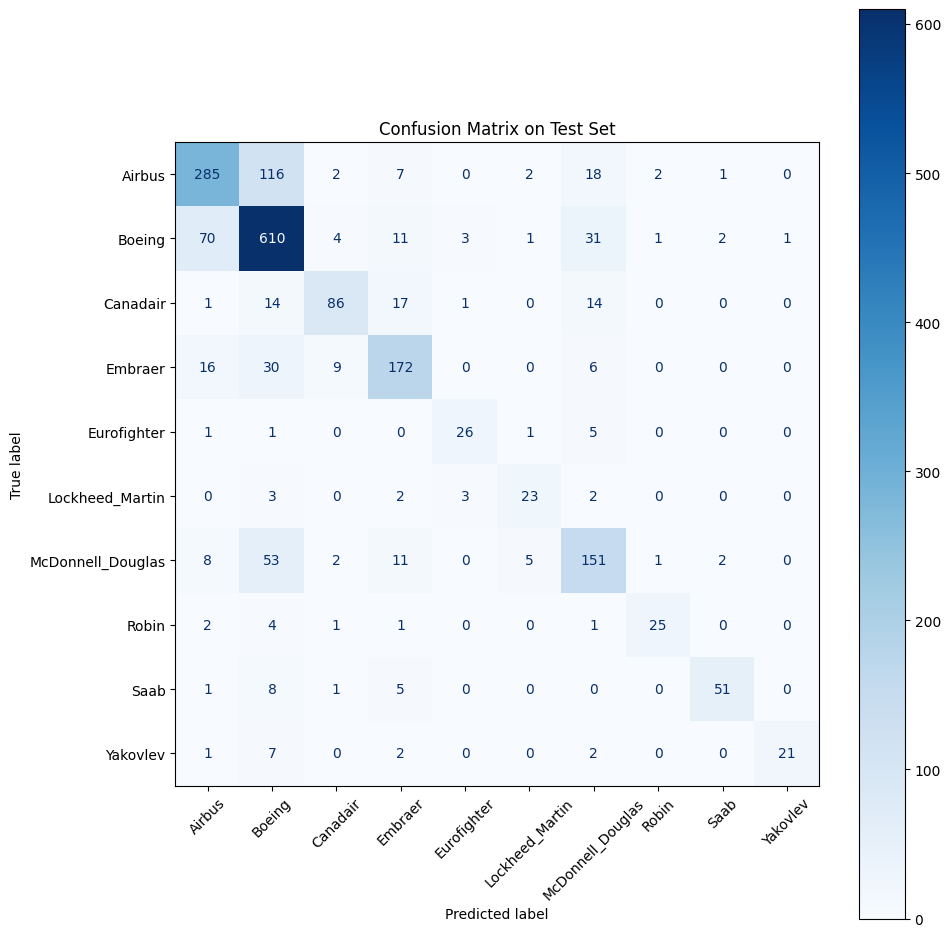

In [ ]:
# Confusion Matrix
class_names = train_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

##ResNet-18 with Pretrained Model

In [ ]:
# ResNet-18 모델 정의
model = models.resnet18(pretrained=True)  # 사전학습 사용
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 모델 학습 (Fine Tuning)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{(correct / total) * 100:.2f}%"
        })

    epoch_acc = correct / total * 100
    print(f"[Epoch {epoch+1}] Total Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/10: 100%|██████████| 123/123 [00:16<00:00,  7.63it/s, Loss=0.6399, Acc=62.33%]


[Epoch 1] Total Loss: 125.4886, Accuracy: 62.33%


Epoch 2/10: 100%|██████████| 123/123 [00:16<00:00,  7.68it/s, Loss=0.6695, Acc=84.14%]


[Epoch 2] Total Loss: 53.3231, Accuracy: 84.14%


Epoch 3/10: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s, Loss=0.1333, Acc=90.95%]


[Epoch 3] Total Loss: 32.2606, Accuracy: 90.95%


Epoch 4/10: 100%|██████████| 123/123 [00:15<00:00,  7.77it/s, Loss=0.3916, Acc=93.80%]


[Epoch 4] Total Loss: 21.3684, Accuracy: 93.80%


Epoch 5/10: 100%|██████████| 123/123 [00:15<00:00,  7.72it/s, Loss=0.3431, Acc=93.90%]


[Epoch 5] Total Loss: 21.2608, Accuracy: 93.90%


Epoch 6/10: 100%|██████████| 123/123 [00:15<00:00,  7.85it/s, Loss=0.1149, Acc=96.62%]


[Epoch 6] Total Loss: 12.5399, Accuracy: 96.62%


Epoch 7/10: 100%|██████████| 123/123 [00:15<00:00,  7.90it/s, Loss=0.0898, Acc=97.97%]


[Epoch 7] Total Loss: 7.5555, Accuracy: 97.97%


Epoch 8/10: 100%|██████████| 123/123 [00:15<00:00,  7.84it/s, Loss=0.0450, Acc=97.51%]


[Epoch 8] Total Loss: 9.2496, Accuracy: 97.51%


Epoch 9/10: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s, Loss=0.0698, Acc=98.17%]


[Epoch 9] Total Loss: 7.0626, Accuracy: 98.17%


Epoch 10/10: 100%|██████████| 123/123 [00:15<00:00,  7.79it/s, Loss=0.0107, Acc=97.03%]

[Epoch 10] Total Loss: 10.4972, Accuracy: 97.03%


In [ ]:
# 모델 테스트
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in test_pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Evaluating: 100%|██████████| 62/62 [00:06<00:00,  8.93it/s]

Test Accuracy: 84.28%


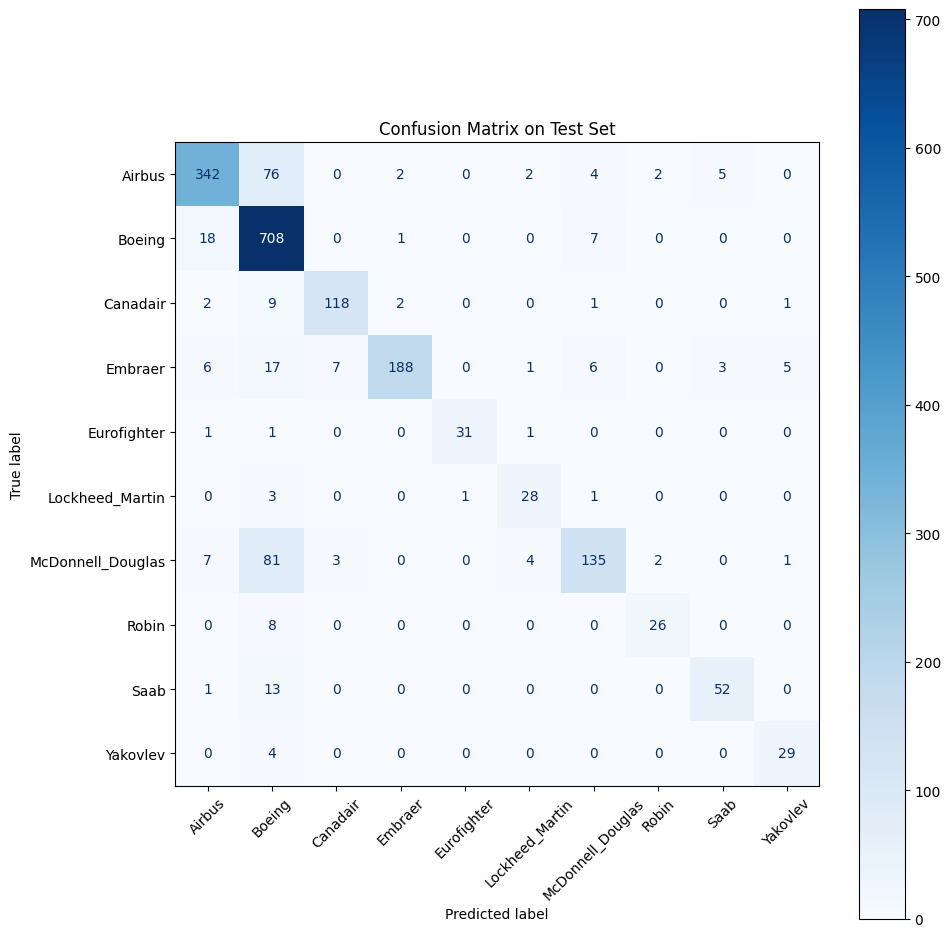

In [ ]:
class_names = train_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

##Pretrained ViT

In [ ]:
# ViT 모델 불러오기 + head 교체
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)  # ViT는 AdamW 권장

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{(correct / total) * 100:.2f}%"
        })

    epoch_acc = correct / total * 100
    print(f"[Epoch {epoch+1}] Total Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Evaluating: 100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Test Accuracy: 95.17%


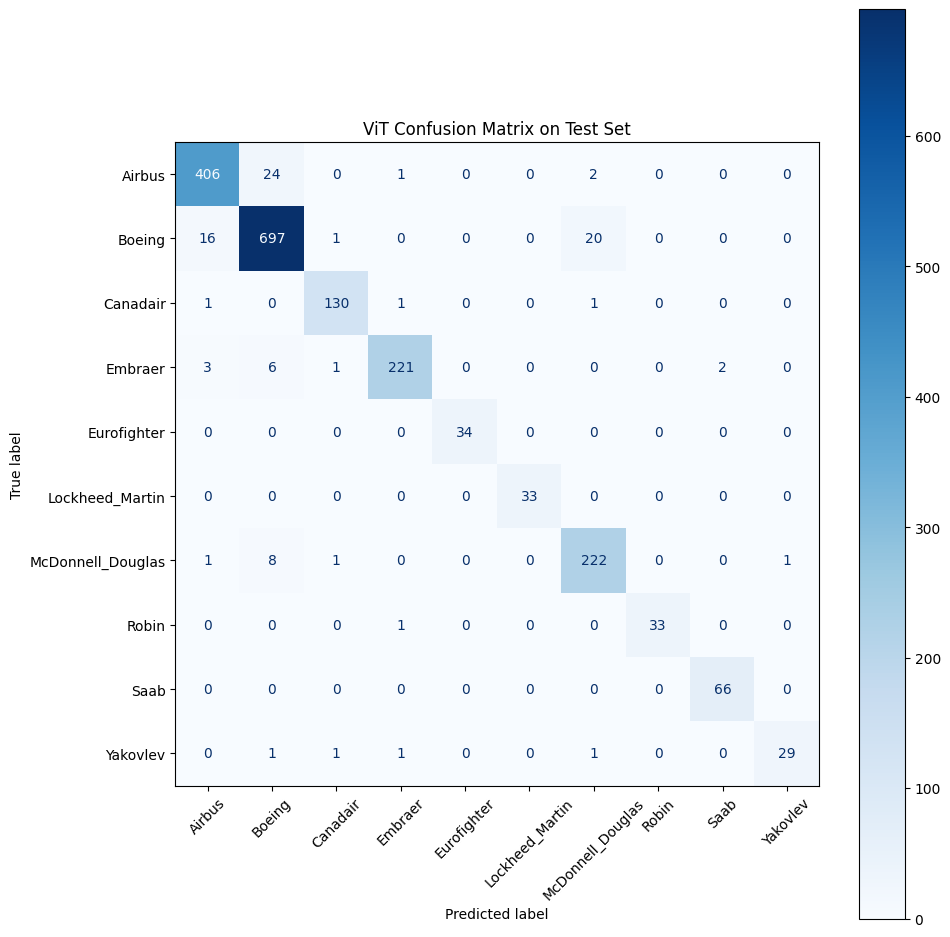

In [ ]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in test_pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {correct / total * 100:.2f}%")

# Confusion Matrix
class_names = train_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("ViT Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()